In [182]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

In [183]:


cols = [('A','pop'),('A','dead'),('B','pop'),('B','dead')]

# example populations of two countries

df2 = pd.DataFrame(data=[[100000,100,900000,900], #child: pop,dead,pop,dead : A,B
                         [900000,9000,100000,1000]],    #adult pop,dead : A,B
                   columns=pd.MultiIndex.from_tuples(cols),index=['child','adult'])

# define a standard population, by age groups
standard_pop = pd.DataFrame({'child' : [500000],
                            'adult' : [500000]}).T

standard_pop.columns=['pop']

df2

A             B      
          pop  dead     pop  dead
child  100000   100  900000   900
adult  900000  9000  100000  1000

In [184]:
df2_trans = df2.T.unstack().unstack().reset_index()
df2_trans.columns = ['age_grp','state','country','value']
df2_trans
grp = df2_trans.groupby('state')
dead = grp.get_group('dead').reset_index(drop=True)
pop = grp.get_group('pop').reset_index(drop=True)

all_data = pd.concat([pop,dead],axis=1)
all_data = all_data.iloc[:,[2,0,3,7]]

all_data.columns = ['country','age_grp','pop','dead']

def create_country_idx(c):
    if c == 'A' : return  1
    if c == 'B' : return 2
    
def create_age_idx(a):
    if a == 'child' : return 1
    if a == 'adult' : return 2

all_data['country_idx'] = all_data['country'].apply(create_country_idx)
all_data['age_idx'] = all_data['age_grp'].apply(create_age_idx)

all_data

,country,age_grp,pop,dead,country_idx,age_idx
0,A,child,100000,100,1,1
1,B,child,900000,900,2,1
2,A,adult,900000,9000,1,2
3,B,adult,100000,1000,2,2


In [186]:
#PYMC
import pymc as pm
from pymc.Matplot import plot as pmplot


### condition on country by assigning a unique alpha to each country
### condition on age_grp by assigning a unique beta to each age group

# model: 
# dead ~ Binomial(population,p)
# p = logit(alpha[country_idx] + beta[age_idx])
# alpha[country_idx] ~ Normal(0,10)
# beta[age_idx] ~ Normal(0,10) 


country_idx = all_data['country_idx'] 
age_idx = all_data['age_idx']

alpha = pm.Normal('alpha',0, 1 / 10 ** 2,size=2) # 2 countries

beta = pm.Normal('beta',0,1 / 10 ** 2,size=2) # 2 age groups


@pm.deterministic
def logit_age(age_idx=age_idx-1,country_idx=country_idx-1,alpha=alpha,beta=beta):
        
    return np.exp(alpha[country_idx] + beta[age_idx]) / (
        1 + np.exp(alpha[country_idx] + beta[age_idx]))


lkh_age = pm.Binomial('lkh_age',n=all_data['pop'],p=logit_age,observed=True,
                      value=all_data['dead'])

model = pm.Model([alpha,beta,logit_age,lkh_age])

_map = pm.MAP(model)
_map.fit()

mcmc = pm.MCMC(model)
sample = mcmc.sample(50000,20000,3)



 [-----------------100%-----------------] 50000 of 50000 complete in 47.3 sec

In [187]:
def logit_pure(x):
    return (np.exp(x)) / (1 + np.exp(x))

def logistic_pure(p):
    return np.log(p / (1 - p))

Plotting alpha_A
Plotting alpha_B
Plotting beta_child
Plotting beta_adult


,alpha_A,alpha_B,beta_child,beta_adult
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.664161,3.664690,-10.572230,-8.259295
std,0.232867,0.233876,0.235228,0.232783
min,3.195504,3.213723,-11.371299,-8.994930
25%,3.492997,3.493373,-10.714281,-8.398269
50%,3.611173,3.615051,-10.524488,-8.207729
75%,3.803510,3.803727,-10.398781,-8.088610
max,4.394710,4.438728,-10.065422,-7.803609


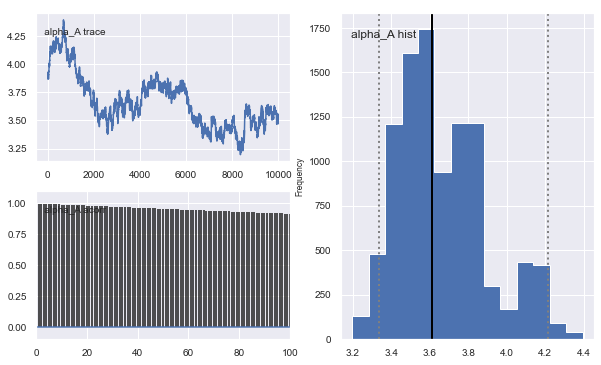

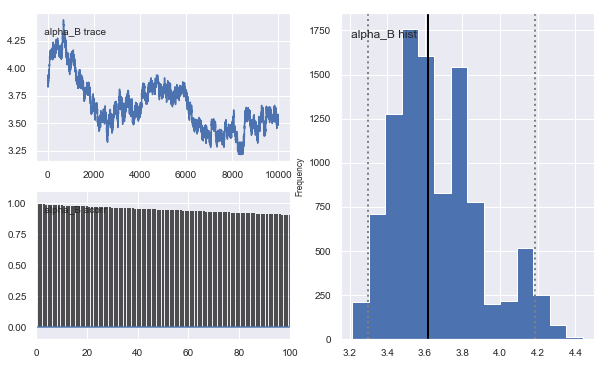

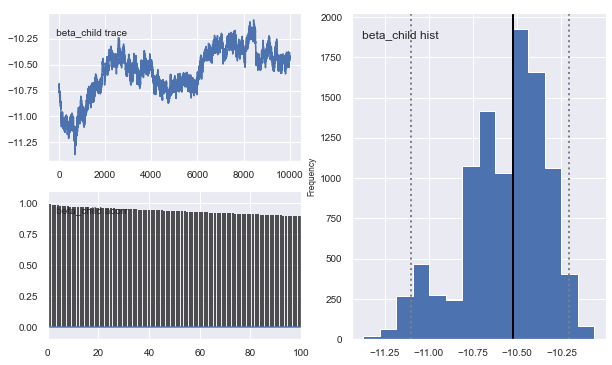

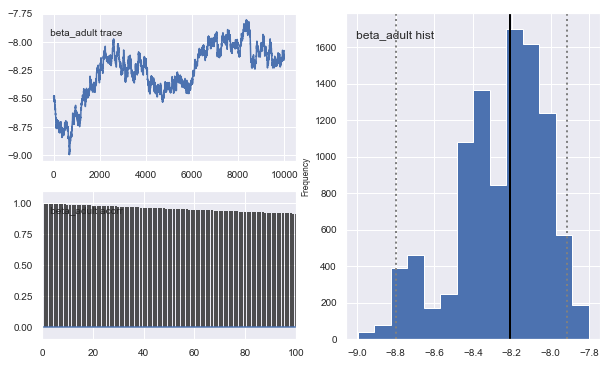

In [188]:
alpha_A = mcmc.trace('alpha')[:,0]
alpha_B = mcmc.trace('alpha')[:,1]

beta_child = mcmc.trace('beta')[:,0]
beta_adult = mcmc.trace('beta')[:,1]

pmplot(alpha_A,'alpha_A')
pmplot(alpha_B,'alpha_B')

pmplot(beta_child,'beta_child')
pmplot(beta_adult,'beta_adult')

result = pd.DataFrame({'alpha_A' : alpha_A,
                      'alpha_B' : alpha_B,
                      'beta_child' : beta_child,
                      'beta_adult' : beta_adult})

result.describe()

In [189]:
result_p = pd.DataFrame()

result_p['A_child'] = logit_pure(result['alpha_A'] + result['beta_child']) 
result_p['A_adult'] = logit_pure(result['alpha_A'] + result['beta_adult']) 
result_p['B_child'] = logit_pure(result['alpha_B'] + result['beta_child']) 
result_p['B_adult'] = logit_pure(result['alpha_B'] + result['beta_adult']) 

result_p.describe()

,A_child,A_adult,B_child,B_adult
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.001000,0.010000,0.001000,0.010009
std,0.000042,0.000104,0.000032,0.000295
min,0.000847,0.009570,0.000882,0.008978
25%,0.000971,0.009931,0.000978,0.009808
50%,0.000998,0.010000,0.000999,0.010008
75%,0.001027,0.010073,0.001021,0.010205
max,0.001154,0.010373,0.001112,0.011169


NameError: name 'std_pop' is not defined

In [225]:
pymc_means = result_p.describe().loc['mean',:]

pymc_deaths_per_M_A_child = pymc_means.loc['A_child'] * standard_pop.loc['child'] 
pymc_deaths_per_M_A_adult = pymc_means.loc['A_adult'] * standard_pop.loc['adult'] 

pymc_deaths_per_M_B_child = pymc_means.loc['B_child'] * standard_pop.loc['child'] 
pymc_deaths_per_M_B_adult = pymc_means.loc['B_adult'] * standard_pop.loc['adult'] 

print (pymc_deaths_per_M_A_child)
print (pymc_deaths_per_M_A_adult)
print (pymc_deaths_per_M_B_child)
print (pymc_deaths_per_M_B_adult)



pop    499.790733
Name: child, dtype: float64
pop    5000.200352
Name: adult, dtype: float64
pop    499.859405
Name: child, dtype: float64
pop    5004.706508
Name: adult, dtype: float64


In [219]:
(pymc_means.loc['A_adult'] * df2.loc['adult',('A','pop')]) / (df2.loc['adult',('A','pop')] / 1e6)

10000.400704796528

In [132]:
df2.loc['All',:] = df2.sum() 


In [133]:
df2[('A','ratio')] = df2[('A','dead')] / df2[('A','pop')]
df2[('B','ratio')] = df2[('B','dead')] / df2[('B','pop')]
df2

A                  B               A       B
             pop    dead        pop    dead   ratio   ratio
child   100000.0   100.0   900000.0   900.0  0.0010  0.0010
adult   900000.0  9000.0   100000.0  1000.0  0.0100  0.0100
All    1000000.0  9100.0  1000000.0  1900.0  0.0091  0.0019

In [134]:
df2 = df2.reindex(columns=[('A','pop'),('A','dead'),('A','ratio'),('B','pop'),('B','dead'),('B','ratio')])

In [135]:
df2[('A','dead_per_M')] = df2[('A','dead')] / (df2[('A','pop')] / 1e6)
df2[('B','dead_per_M')] = df2[('B','dead')] / (df2[('B','pop')] / 1e6)

df2 = df2.reindex(columns=[('A','pop'),('A','dead'),('A','ratio'),('A','dead_per_M'),
                           ('B','pop'),('B','dead'),('B','ratio'),('B','dead_per_M')])

df2

A                                     B                  \
             pop    dead   ratio dead_per_M        pop    dead   ratio   
child   100000.0   100.0  0.0010     1000.0   900000.0   900.0  0.0010   
adult   900000.0  9000.0  0.0100    10000.0   100000.0  1000.0  0.0100   
All    1000000.0  9100.0  0.0091     9100.0  1000000.0  1900.0  0.0019   

                  
      dead_per_M  
child     1000.0  
adult    10000.0  
All       1900.0

In [136]:
standard_pop

,pop
child,500000
adult,500000


In [137]:
standard_pop['expected_A'] = df2[('A','ratio')] * standard_pop['pop']
standard_pop['expected_B'] = df2[('B','ratio')] * standard_pop['pop']
standard_pop.loc['All',:] = standard_pop.sum()
standard_pop['rate_A'] = standard_pop['expected_A'] / standard_pop['pop']
standard_pop['rate_B'] = standard_pop['expected_B'] / standard_pop['pop']
standard_pop['expected_A_per_M'] = standard_pop['expected_A'] / (standard_pop.loc['All','pop'] / 1e6)
standard_pop['expected_B_per_M'] = standard_pop['expected_B'] / (standard_pop.loc['All','pop'] / 1e6)


standard_pop

,pop,expected_A,expected_B,rate_A,rate_B,expected_A_per_M,expected_B_per_M
child,500000.0,500.0,500.0,0.0010,0.0010,500.0,500.0
adult,500000.0,5000.0,5000.0,0.0100,0.0100,5000.0,5000.0
All,1000000.0,5500.0,5500.0,0.0055,0.0055,5500.0,5500.0


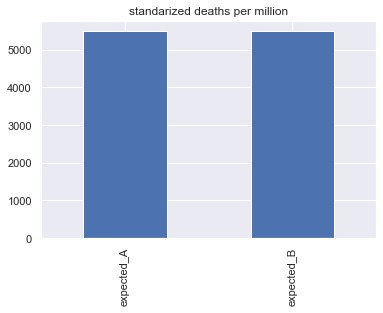

In [138]:
standard_pop.loc['All',['expected_A','expected_B']].plot(kind='bar',title='standarized deaths per million')

In [139]:
##### example on Simpson's Paradox from link below: 

# https://www.healthknowledge.org.uk/e-learning/epidemiology/specialists/standardisation
# fake data from the above link'


df = pd.DataFrame({'age_grp': ['inf','inf','child','child','adult','adult','old','old'],
                  'country' : ['A','B','A','B','A','B','A','B'],
                  'pop' : [1000000,1000000,6000000,1500000,5500000,550000,2500000,120000],
                  'dead' : [1000,1000,7000,6300,20000,3000,120000,6000]})


df['age_grp'] = pd.Categorical(df['age_grp'],['inf','child','adult','old'])

df

,age_grp,country,pop,dead
0,inf,A,1000000,1000
1,inf,B,1000000,1000
2,child,A,6000000,7000
3,child,B,1500000,6300
4,adult,A,5500000,20000
5,adult,B,550000,3000
6,old,A,2500000,120000
7,old,B,120000,6000


In [140]:
pivot = pd.pivot_table(df,index='age_grp',columns='country',values=['pop','dead'],aggfunc=sum,margins=True)
pivot

dead                      pop                   
country       A      B     All         A        B       All
age_grp                                                    
inf        1000   1000    2000   1000000  1000000   2000000
child      7000   6300   13300   6000000  1500000   7500000
adult     20000   3000   23000   5500000   550000   6050000
old      120000   6000  126000   2500000   120000   2620000
All      148000  16300  164300  15000000  3170000  18170000

In [141]:
pivot['age_ratio_A'] = pivot[('pop','A')] / pivot.loc['All',('pop','A')]
pivot['age_ratio_B'] = pivot[('pop','B')] / pivot.loc['All',('pop','B')]

pivot['dead_ratio_A'] = pivot[('dead','A')] / pivot[('pop','A')]
pivot['dead_ratio_B'] = pivot[('dead','B')] / pivot[('pop','B')]

pivot['delta_dead_ratio'] = pivot['dead_ratio_B'] - pivot['dead_ratio_A']
pivot['factor'] = pivot['dead_ratio_B'] / pivot['dead_ratio_A']

pivot

dead                      pop                    age_ratio_A  \
country       A      B     All         A        B       All               
age_grp                                                                   
inf        1000   1000    2000   1000000  1000000   2000000    0.066667   
child      7000   6300   13300   6000000  1500000   7500000    0.400000   
adult     20000   3000   23000   5500000   550000   6050000    0.366667   
old      120000   6000  126000   2500000   120000   2620000    0.166667   
All      148000  16300  164300  15000000  3170000  18170000    1.000000   

        age_ratio_B dead_ratio_A dead_ratio_B delta_dead_ratio    factor  
country                                                                   
age_grp                                                                   
inf        0.315457     0.001000     0.001000         0.000000  1.000000  
child      0.473186     0.001167     0.004200         0.003033  3.600000  
adult      0.173502     0.003636     0.005455         0.001818  1.500000  
old        0.037855     0.048000     0.050000         0.002000  1.041667  
All        1.000000     0.009867     0.005142        -0.004725  0.521144

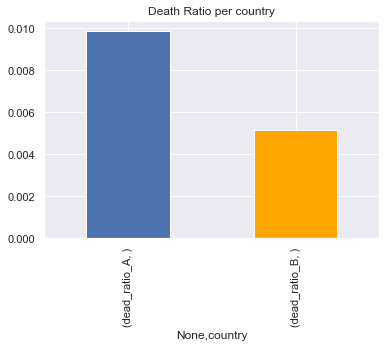

In [142]:
# for the fake data, the observation here is that Simpson's Paradox strikes again - overall country A has higher death ratio,
# despite the fact that it has lower death ratios in each age group. 

pivot.loc['All','dead_ratio_A' : 'dead_ratio_B'].plot(kind='bar',color=['b','orange'],title='Death Ratio per country')

Text(0, 0.5, 'percentage')

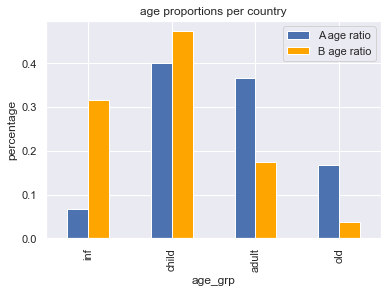

In [143]:
pivot.loc[:'old','age_ratio_A':'age_ratio_B'].plot(kind='bar',
                                                   color=['b','orange'],title='age proportions per country')
plt.legend(['A age ratio','B age ratio'])
plt.ylabel('percentage')

Text(0, 0.5, 'percentage')

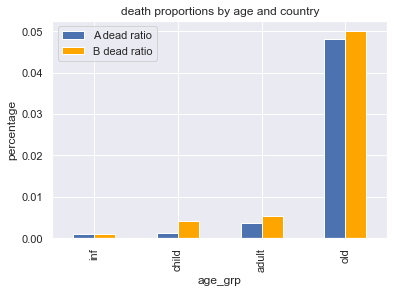

In [144]:
pivot.loc[:'old','dead_ratio_A': 'dead_ratio_B'].plot(kind='bar',
                                                     color=['b','orange'],title='death proportions by age and country')
plt.legend(['A dead ratio','B dead ratio'])
plt.ylabel('percentage')

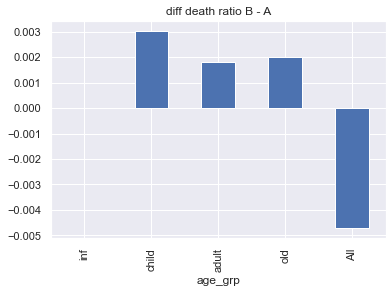

In [145]:
pivot['delta_dead_ratio'].plot(kind='bar',title='diff death ratio B - A')

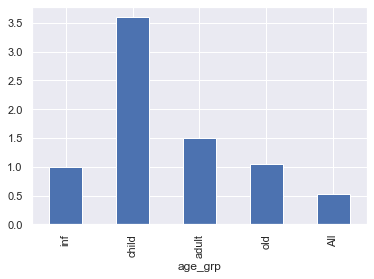

In [146]:
pivot['factor'].plot(kind='bar')